### load the monthly CMIP5 rcp85 RAW files and do some data cleaning

* lots of trouble with dates till 2300 using datatime64
* convert all times to enso time

* IPSL-CM5A-LR has a problematic time grid since one file goes from 2006 to 2300
* NorESM1-ME has trouble with lat grid when using xr.open_mfdataset  (see mfdataset_trouble.ipynb)
* to_netcdf encodes time,lon,lat as integers - trouble for ncview (time is interpreted as days, lon,lat are ignored and 0:nx,0:ny are used instead

In [49]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from glob import glob
import os, sys
sys.path.append("/home2/nhn2/py_packages")
from myplots.cplot import my_contourf
from tqdm import tqdm
from mytools.LG_xarray_tools import xarray_trend
import pandas as pd

In [59]:
# lets get started using the 1x1 degree 40 models that Haibo has on kage:

recompute = False

#scenario ='historical'
scenario ='rcp85'
var = 'ts'

path = '/net/stregone/home/naomi/Raws/histPrcp85/*/'+scenario+'/atmos/mon/'+var

files = glob(path + '/r1i1p1/*.nc')
models=[]
for file in files:
    models += [file.split("/")[-7]]

umodels = sorted(list(set(models)))

In [91]:
start_dates=[]
m=0
for model in umodels:
    path = '/net/stregone/home/naomi/Raws/histPrcp85/'+model+'/'+scenario+'/atmos/mon/'+var
    files = sorted(glob(path + '/r1i1p1/*.nc'))
    file1 = files[0]   
    
    # open the first file to get the start date:
    if model in 'IPSL-CM5A-LR':  # this file is 200601-230012, so can't use decode_times to get any info
        start = '2006-01-16'
    else:
        dss = xr.open_dataset(file1,decode_times=True,autoclose=True)
        start = dss.time.values[0]

    start_dates += [start] 
    
    # open again to get the units and calendar:
    dss = xr.open_dataset(file1,decode_times=False,autoclose=True)
    
    fstr = '{:2} {:18} units = {:.21} \t calendar =  {:20} start_date = {:.30}'
    print(fstr.format(m,model,dss.time.attrs['units'],dss.time.attrs['calendar'],start))
    m += 1

 0 ACCESS1-0          units = days since 0001-01-01 	 calendar =  proleptic_gregorian  start_date = 2006-01-16T12:00:00.000000000
 1 ACCESS1-3          units = days since 0001-01-01 	 calendar =  proleptic_gregorian  start_date = 2006-01-16T12:00:00.000000000
 2 BNU-ESM            units = days since 2006-01-01 	 calendar =  noleap               start_date = 2006-01-16T12:00:00.000000000
 3 CCSM4              units = days since 2005-01-01 	 calendar =  noleap               start_date = 2005-01-16T12:00:00.000000000
 4 CESM1-BGC          units = days since 2005-01-01 	 calendar =  noleap               start_date = 2006-01-16T12:00:00.000000000
 5 CESM1-CAM5         units = days since 2006-01-01 	 calendar =  noleap               start_date = 2006-01-16T12:00:00.000000000
 6 CESM1-CAM5-1-FV2   units = days since 2006-01-01 	 calendar =  noleap               start_date = 2006-01-16T12:00:00.000000000
 7 CMCC-CESM          units = days since 2000-1-1 	 calendar =  standard             start

In [92]:
from ingrid.times import to_enso, enso2date, to_pandas
ds = []
good_models = []
num = 0
#for model in tqdm(umodels):
for model,start_date in zip(umodels,start_dates):
    path = '/net/stregone/home/naomi/Raws/histPrcp85/'+model+'/'+scenario+'/atmos/mon/'+var
    files = sorted(glob(path + '/r1i1p1/*.nc'))
    num_files = np.shape(files)[0]   
    if num_files:
        dss = xr.open_mfdataset(files,decode_times=False,autoclose=True)
        nt = dss.time.shape[0]
        dss['time'] = to_enso(str(start_date),nt)
        ds += [dss[var]]
        good_models += [model]
        dx = (dss.lon[1]-dss.lon[0]).values
        dy = (dss.lat[1]-dss.lat[0]).values
        tfirst = enso2date(dss.time[0].values)
        tlast = enso2date(dss.time[-1].values)
        fstr = '{:2g}: {:18} num_files={:2g}, {:.19} to {:.19}, dx={:04.2f}, dy={:04.2f}, {:5.1f}Mb'
        print(fstr.format(num,model,num_files,tfirst,tlast,dx,dy,dss.nbytes/ 1e6))
        num += 1
    else:
        print('no files available')

 0: ACCESS1-0          num_files= 1, 2006/1/16 to 2100/12/16, dx=1.88, dy=1.25, 127.0Mb
 1: ACCESS1-3          num_files= 1, 2006/1/16 to 2100/12/16, dx=1.88, dy=1.25, 127.0Mb
 2: BNU-ESM            num_files= 1, 2006/1/16 to 2100/12/16, dx=2.81, dy=2.77,  37.4Mb
 3: CCSM4              num_files= 1, 2005/1/16 to 2100/12/16, dx=1.25, dy=0.94, 254.8Mb
 4: CESM1-BGC          num_files= 1, 2006/1/16 to 2100/12/16, dx=1.25, dy=0.94, 252.2Mb
 5: CESM1-CAM5         num_files= 1, 2006/1/16 to 2100/12/16, dx=1.25, dy=0.94, 252.2Mb
 6: CESM1-CAM5-1-FV2   num_files= 1, 2006/1/16 to 2099/10/16, dx=2.50, dy=1.89,  62.3Mb
 7: CMCC-CESM          num_files=12, 2000/1/16 to 2100/12/16, dx=3.75, dy=3.68,  25.2Mb
 8: CMCC-CM            num_files=10, 2006/1/16 to 2100/12/16, dx=0.75, dy=0.74, 538.5Mb
 9: CMCC-CMS           num_files=10, 2006/1/16 to 2100/12/16, dx=1.88, dy=1.85,  89.3Mb
10: CNRM-CM5           num_files= 6, 2006/1/16 to 2300/12/16, dx=1.41, dy=1.39, 485.8Mb
11: CSIRO-Mk3-6-0      num_files

In [103]:
# now we will interpolate in (lon,lat)
import xesmf as xe

start = to_enso('2006-01-16')[0]
stop = to_enso('2100-12-16')[0]

In [104]:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89,89, 2)),
                     'lon': (['lon'], np.arange(-179,179,2)),
                    })

In [105]:
# trouble with duplication in lat entries for NorESM1-ME:
mtrouble = umodels.index('NorESM1-ME')
umodels[mtrouble],ds[mtrouble].lat

ValueError: 'NorESM1-ME' is not in list

In [106]:
if 'NorESM1-ME' in umodels:
    mtrouble = umodels.index('NorESM1-ME')
    del umodels[mtrouble],ds[mtrouble]
    
ts_2x2 =[]
for model,dss in zip(umodels,ds):
    print(model)
    regridder = xe.Regridder(dss, ds_out, 'bilinear', periodic=True, reuse_weights=True )
    ts_2x2 += [regridder(dss.sel(time=slice(start, stop)))]

ACCESS1-0
Reuse existing file: bilinear_145x192_89x179_peri.nc
ACCESS1-3
Reuse existing file: bilinear_145x192_89x179_peri.nc
BNU-ESM
Reuse existing file: bilinear_64x128_89x179_peri.nc
CCSM4
Reuse existing file: bilinear_192x288_89x179_peri.nc
CESM1-BGC
Reuse existing file: bilinear_192x288_89x179_peri.nc
CESM1-CAM5
Reuse existing file: bilinear_192x288_89x179_peri.nc
CESM1-CAM5-1-FV2
Reuse existing file: bilinear_96x144_89x179_peri.nc
CMCC-CESM
Reuse existing file: bilinear_48x96_89x179_peri.nc
CMCC-CM
Reuse existing file: bilinear_240x480_89x179_peri.nc
CMCC-CMS
Reuse existing file: bilinear_96x192_89x179_peri.nc
CNRM-CM5
Reuse existing file: bilinear_128x256_89x179_peri.nc
CSIRO-Mk3-6-0
Reuse existing file: bilinear_96x192_89x179_peri.nc
CanESM2
Reuse existing file: bilinear_64x128_89x179_peri.nc
FGOALS-g2
Reuse existing file: bilinear_60x128_89x179_peri.nc
FGOALS-s2
Reuse existing file: bilinear_108x128_89x179_peri.nc
FIO-ESM
Reuse existing file: bilinear_64x128_89x179_peri.nc
GFD

In [115]:
from datetime import date, timedelta
dsall = xr.concat(ts_2x2,dim='model')

datetime = date(2006,1,1) 
dsall['time'] = pd.date_range(datetime, periods=dsall.time.shape[0], freq='MS').shift(15, freq='D')

5.8116288 Gb


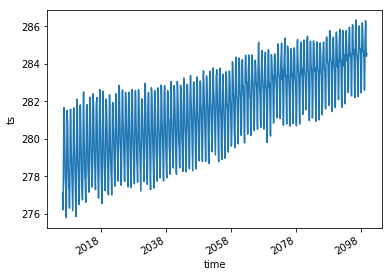

In [123]:
print(dsall.nbytes / 1e9,'Gb')


In [134]:
dclim = dsall.groupby('time.month').mean(dim='time')
danom = dsall.groupby('time.month') - dclim
del danom['month']

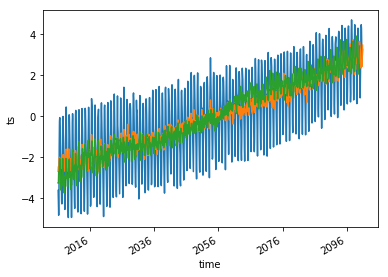

In [139]:
(dsall.isel(model=0)-dsall.isel(model=0).mean('time')).mean(['lat','lon']).plot()
danom.isel(model=0).mean(['lat','lon']).plot()
danom.isel(model=24).mean(['lat','lon']).plot()

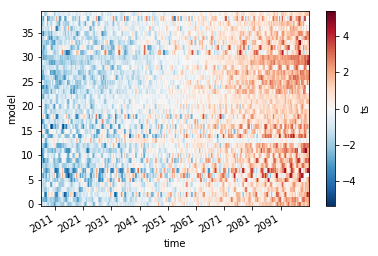

In [140]:
danom.sel(lon=slice(-170,-120),lat=slice(-5,5)).mean(['lat','lon']).plot()

In [141]:
danom.to_netcdf('rcp85-anom-ints.nc')
danom.to_netcdf('rcp85-anom.nc',encoding={'time':{'dtype':'float32'},'lon':{'dtype':'float32'},'lat':{'dtype':'float32'}})